In [2]:
import os
import torch
import random
from einops import rearrange
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torchvision import models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
import albumentations as A

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class APTOSDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0] + ".png"
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [20]:
def datasetLoad():
    # Transformations
    transform = T.Compose([
        T.Resize((224, 224)),  # ConvNeXt expects 224x224 input
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = APTOSDataset(
        csv_file="./datasetCCP/train_1.csv",
        image_dir="./datasetCCP/train_images",
        transform=transform
    )

    val_dataset = APTOSDataset(
        csv_file="./datasetCCP/valid.csv",
        image_dir="./datasetCCP/val_images",
        transform=transform
    )

    test_dataset = APTOSDataset(
        csv_file="./datasetCCP/test.csv",
        image_dir="./datasetCCP/test_images",
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    return train_loader,val_loader,test_loader
    

In [6]:
def prediction(model,image_path):
    model.eval()

    class_names = [
        "no DR", 
        "mild DR", 
        "moderate DR", 
        "severe DR", 
        "proliferative DR"
    ]

    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = predicted.item()

    print(f"Predicted class: {class_names[predicted_class]}")


In [7]:
def evaluation(model, test):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_images = []
    all_probs = []

    class_names = [
        "no DR", 
        "mild DR", 
        "moderate DR", 
        "severe DR", 
        "proliferative DR"]
    
    num_classes = len(class_names)

    with torch.no_grad():
        loop = tqdm(test, desc="Testing", leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix({
                'Acc': f'{100 * correct / total:.2f}%'
            })

    # Metrics
    final_acc = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {final_acc * 100:.2f}%\n")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Show 5 random images with predictions
    print("\nSample Predictions:")
    indices = random.sample(range(len(all_images)), 5)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        image = all_images[idx]
        true_label = class_names[all_labels[idx]]
        pred_label = class_names[all_preds[idx]]

        # De-normalize
        img_np = image.permute(1, 2, 0).numpy()
        img_np = (img_np * std) + mean
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.tight_layout()
    plt.show()

    # ROC Curve (One-vs-Rest)
    print("\nROC Curve:")
    all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiclass')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [43]:
class ConvNeXtCNNHybrid(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super().__init__()

        # Load ConvNeXt-Tiny as feature extractor
        self.backbone = models.convnext_tiny(weights="IMAGENET1K_V1")
        self.backbone.classifier = nn.Identity()  # Remove the original classifier

        # Freeze ConvNeXt weights
        for param in self.backbone.parameters():
            param.requires_grad = False

        # CNN head
        self.cnn_head = nn.Sequential(
            nn.Conv2d(768, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.AdaptiveAvgPool2d((1, 1)),  # Reduce to [B, 256, 1, 1]
            nn.Flatten(),                  # Shape: [B, 256]
            nn.Linear(256, num_classes)   # Final classifier
        )

    def forward(self, x):
        x = self.backbone.features(x)  # Output shape: [B, 768, 7, 7]
        x = self.cnn_head(x)
        return x

In [44]:
def convNextModel(epochs, num_classes, train, valid, dropout_rate=0.3):
    model = ConvNeXtCNNHybrid(num_classes=num_classes,dropout_rate=dropout_rate)

    # Replace the classifier with dropout added
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    epoch_losses = []
    epoch_accuracies = []
    val_losses = []
    val_accuracies = []
    vram_usage = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train, desc=f"Epoch [{epoch+1}/{epochs}] Train", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix({
                'Loss': f'{running_loss / total:.4f}',
                'Acc': f'{100 * correct / total:.2f}%'
            })

        epoch_loss = running_loss / len(train.dataset)
        epoch_acc = 100 * correct / len(train.dataset)
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in valid:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / len(valid.dataset)
        val_acc = 100 * val_correct / len(valid.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

        if torch.cuda.is_available():
            mem_alloc = torch.cuda.memory_allocated(device) / (1024 ** 2)
            mem_reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
            print(f"VRAM allocated: {mem_alloc:.2f} MB, VRAM reserved: {mem_reserved:.2f} MB")
            vram_usage.append(mem_alloc)
        else:
            vram_usage.append(0)

    # Plot loss and accuracy
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, epoch_losses, 'r-', label='Train Loss')
    plt.plot(epochs_range, val_losses, 'g-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, epoch_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, 'm-', label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [45]:
train,valid,test = datasetLoad()

Epoch [1/10] Train Loss: 0.0235 Acc: 74.23% | Val Loss: 0.0206 Acc: 78.14%
VRAM allocated: 1708.19 MB, VRAM reserved: 8360.00 MB


Epoch [2/10] Train Loss: 0.0169 Acc: 81.26% | Val Loss: 0.0217 Acc: 74.32%
VRAM allocated: 1708.19 MB, VRAM reserved: 8360.00 MB


Epoch [3/10] Train Loss: 0.0147 Acc: 83.00% | Val Loss: 0.0185 Acc: 81.15%
VRAM allocated: 1708.19 MB, VRAM reserved: 8360.00 MB


Epoch [4/10] Train Loss: 0.0139 Acc: 84.20% | Val Loss: 0.0175 Acc: 81.42%
VRAM allocated: 1708.19 MB, VRAM reserved: 8360.00 MB


Epoch [5/10] Train Loss: 0.0125 Acc: 85.39% | Val Loss: 0.0185 Acc: 79.51%
VRAM allocated: 1708.19 MB, VRAM reserved: 8360.00 MB


Epoch [6/10] Train Loss: 0.0113 Acc: 87.13% | Val Loss: 0.0180 Acc: 80.33%
VRAM allocated: 1708.19 MB, VRAM reserved: 8360.00 MB


Epoch [7/10] Train Loss: 0.0102 Acc: 88.77% | Val Loss: 0.0177 Acc: 79.78%
VRAM allocated: 1708.19 MB, VRAM reserved: 8360.00 MB


Epoch [8/10] Train Loss: 0.0097 Acc: 89.56% | Val Loss: 0.0166 Acc: 82.51%
VRAM allocated: 1708.19 MB, VRAM reserved: 8360.00 MB


Epoch [9/10] Train Loss: 0.0088 Acc: 90.27% | Val Loss: 0.0179 Acc: 78.69%
VRAM allocated: 1708.19 MB, VRAM reserved: 8360.00 MB


Epoch [10/10] Train Loss: 0.0079 Acc: 91.71% | Val Loss: 0.0192 Acc: 81.42%
VRAM allocated: 1708.19 MB, VRAM reserved: 8360.00 MB


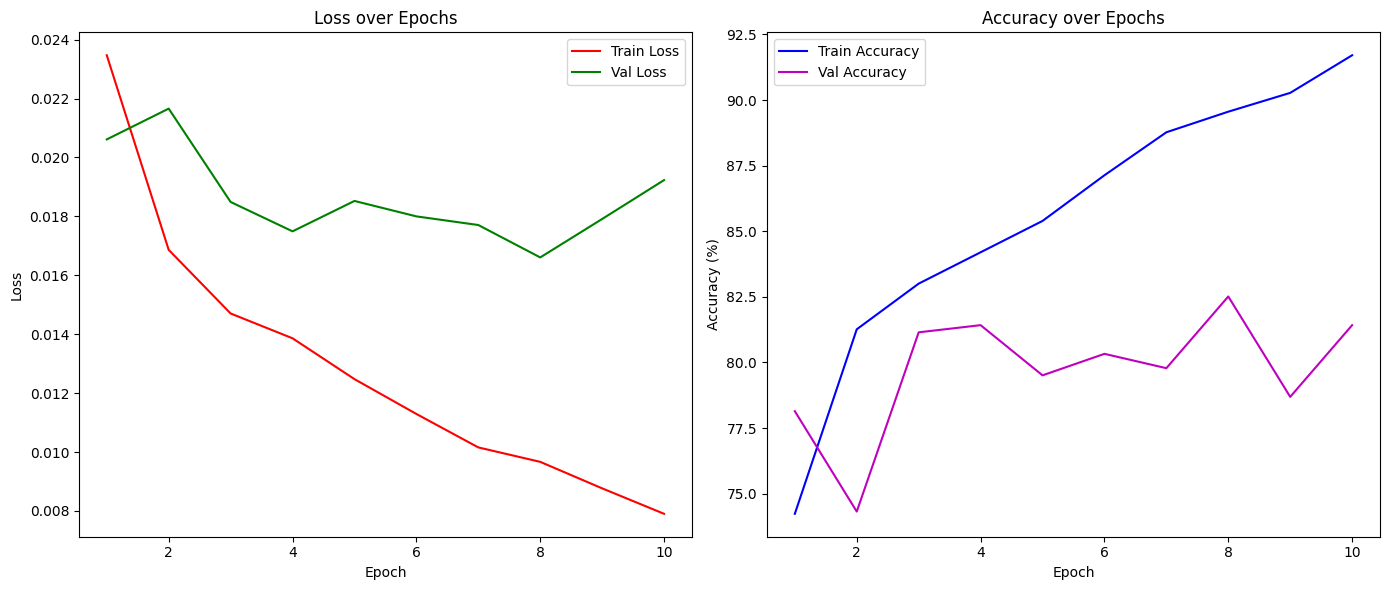

In [46]:
model=convNextModel(epochs=10,num_classes=5,train=train,valid=valid)

In [47]:
torch.save(model, 'modelconvnextA3-10.pth')

In [48]:
model=torch.load("modelconvnextA2-10.pth",weights_only=False)

In [49]:
prediction(model,"./check3.png")

Predicted class: moderate DR



Test Accuracy: 84.15%

Classification Report:
                  precision    recall  f1-score   support

           no DR       0.98      0.98      0.98       199
         mild DR       0.64      0.53      0.58        30
     moderate DR       0.71      0.83      0.76        87
       severe DR       0.37      0.41      0.39        17
proliferative DR       0.89      0.52      0.65        33

        accuracy                           0.84       366
       macro avg       0.72      0.65      0.67       366
    weighted avg       0.85      0.84      0.84       366



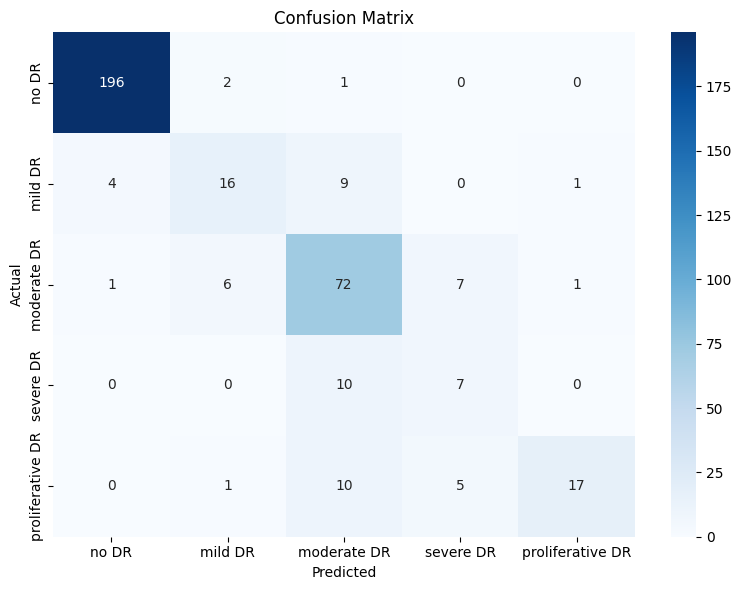


Sample Predictions:


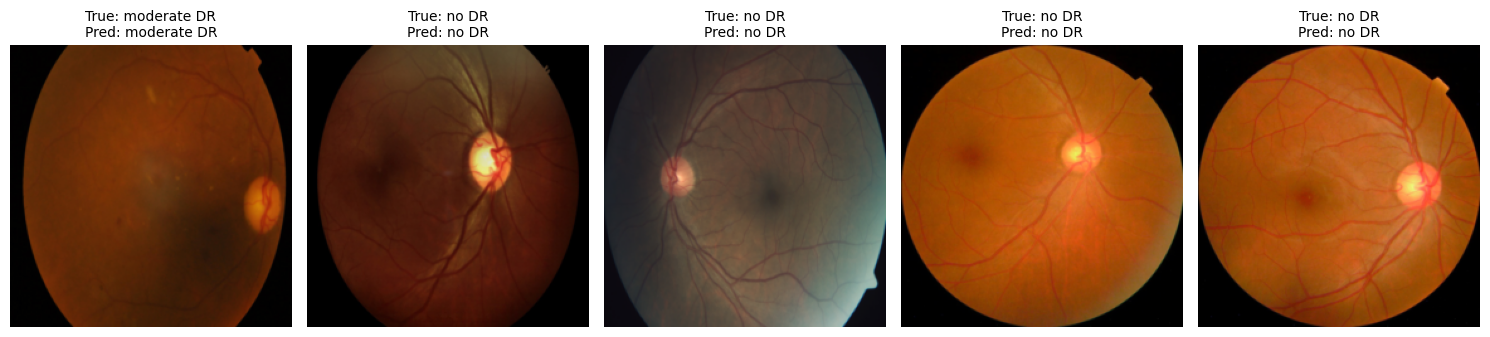


ROC Curve:


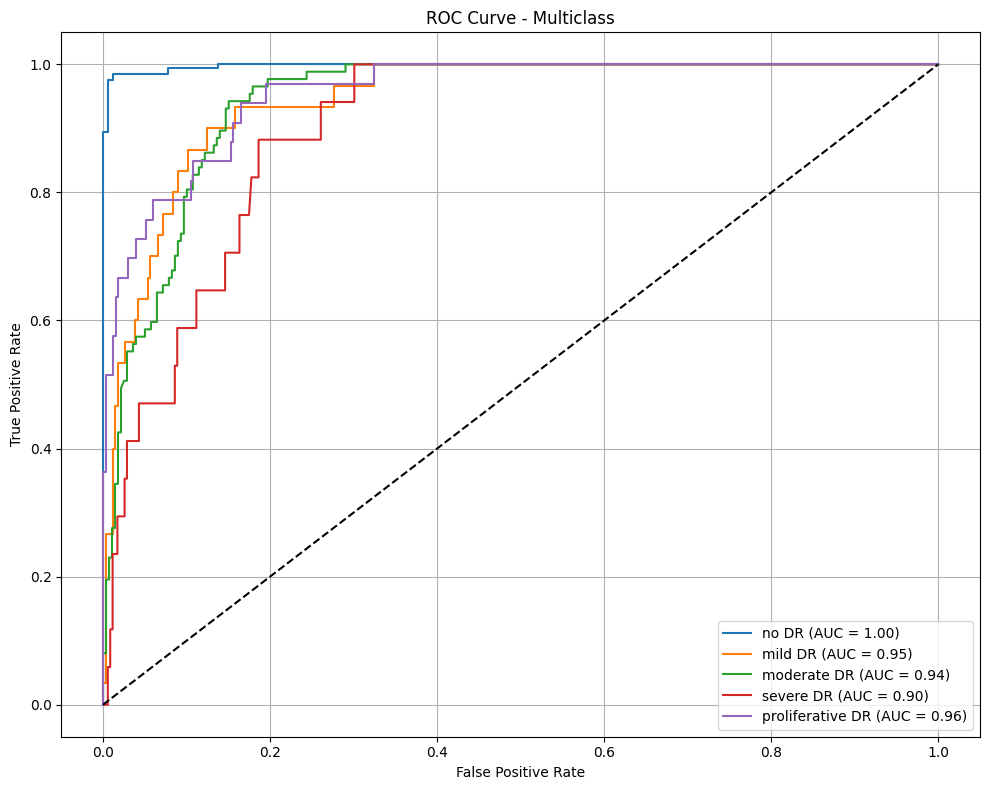

In [50]:
evaluation(model,test)